# Performing Forced Photometry on HSC Filters G, R, I, Z and Y, and HST Filters F110 and F160


### This notebook takes the Z filter image of HSC, finds sources and performs forced photometry on other filters.

Importing required packages

In [2]:
import astropy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import fits
from photutils.segmentation import detect_sources
from astropy.stats import SigmaClip, sigma_clipped_stats
from photutils.segmentation import SourceFinder, SourceCatalog
from photutils.segmentation import deblend_sources
from astropy.wcs import WCS, wcs
from scipy import ndimage, datasets
from photutils.segmentation import make_2dgaussian_kernel
from astropy.convolution import convolve
from photutils.background import SExtractorBackground, MeanBackground
from astropy import units as u
from astropy import table
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from astropy.table import QTable as Table
from photutils.aperture import BoundingBox, Aperture, PixelAperture, ApertureMask, EllipticalAperture, SkyEllipticalAperture, aperture_photometry

**Storing the locations of required files**


In [3]:
HSC_G_name    = '/mnt/c/Workspace/zgalevo/Examples/HSC/2-cutout-HSC-G-9075-pdr3_wide.fits'
HSC_R_name    = '/mnt/c/Workspace/zgalevo/Examples/HSC/3-cutout-HSC-R-9075-pdr3_wide.fits'
HSC_I_name    = '/mnt/c/Workspace/zgalevo/Examples/HSC/4-cutout-HSC-I-9075-pdr3_wide.fits'
HSC_Z_name    = '/mnt/c/Workspace/zgalevo/Examples/HSC/5-cutout-HSC-Z-9075-pdr3_wide.fits'
HSC_Y_name    = '/mnt/c/Workspace/zgalevo/Examples/HSC/6-cutout-HSC-Y-9075-pdr3_wide.fits'

HST_F110_name = '/mnt/c/Workspace/zgalevo/Examples/HST/ibjj05010/ibjj05010_drz.fits'
HST_F160_name = '/mnt/c/Workspace/zgalevo/Examples/HST/ibjj05030/ibjj05030_drz.fits'

## **Photometry on Z Band**

Checking the extensions in Z file

In [4]:
fits.info(HSC_Z_name)

Filename: /mnt/c/Workspace/zgalevo/Examples/HSC/5-cutout-HSC-Z-9075-pdr3_wide.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   ()      
  1                1 ImageHDU        31   (5955, 5953)   float32   
  2                1 ImageHDU        48   (5955, 5953)   int32   
  3                1 ImageHDU        31   (5955, 5953)   float32   


Opening Z file

In [5]:
open_HSC_Z = fits.open(HSC_Z_name)            # To open the file
img_HSC_Z  = open_HSC_Z[1]                    # Choosing the subset with required data
data_HSC_Z = img_HSC_Z.data.astype('float32') # Saving the data from that subset

Plotting the image

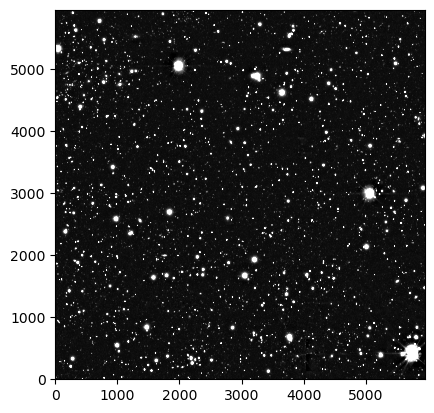

In [6]:
plt.imshow(data_HSC_Z, origin='lower', cmap = 'Greys_r', vmax=2, vmin=-.1)

Viewing the header

In [24]:
header_Z = WCS(img_HSC_Z.header) 
header_Z

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 135.371900826446  -2.23140495867768  
CRPIX : 11336.0  -8606.0  
CD1_1 CD1_2  : -4.666666666664e-05  0.0  
CD2_1 CD2_2  : 0.0  4.66666666666372e-05  
NAXIS : 5955  5953

Subtracting an estimate of the background using SEXtractor

In [8]:
sigma_clip = SigmaClip(sigma=3.0)           # Sigma Clipping the image
bkg = MeanBackground(sigma_clip)            
bkg_value = bkg.calc_background(data_HSC_Z) # Finding mean background value
filt_data_HSC_Z = data_HSC_Z - bkg_value    # Subtracting the mean background from the actual data and getting a filtered data

Plotting both filtered and actual image

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

ax1 = plt.subplot(1, 2, 1, projection = header_Z)
ax1.imshow(data_HSC_Z, origin='lower', cmap = 'Greys_r', vmax=2, vmin=-.1)
ax2 = plt.subplot(1, 2, 2, projection = header_Z)
ax2.imshow(filt_data_HSC_Z, origin='lower', cmap = 'Greys_r', vmax=2, vmin=-.1)

Using ds9, find too bright sources and mask them. R and I bands have captured a satellite image, mask them too using ds9.

In [9]:
mask = np.zeros(shape = filt_data_HSC_Z.shape, dtype = bool) # Creating an ndarray
# With the help of ds9, masking bigger sources as we don't need them for our work
mask[201:626, 5518:5907].fill(True)
mask[565:751, 3698:3842].fill(True)
mask[2844:3118, 4939:5180].fill(True)
mask[4780:4953, 3138:3333].fill(True)
mask[1581:1729, 2970:3140].fill(True)
mask[4904:5173, 1892:2125].fill(True)
mask[2621:2752, 1776:1923].fill(True)
mask[5265:5339, 3642:3812].fill(True)
mask[5236:5403, 0:124].fill(True)
mask[2068:2187, 4954:5071].fill(True)
mask[1857:1989, 3148:3273].fill(True)
mask[4532:4683, 3573:3730].fill(True)
mask[759:900, 1408:1535].fill(True)
mask[883:889, 1443:1450].fill(True)
mask[892:898, 1444:1449].fill(True)
mask[903:909, 1446:1451].fill(True)
mask[863:867, 122:1526].fill(True)
mask[953:959, 1549:1553].fill(True)
mask[1918:1923, 1113:1119].fill(True)
mask[857:935, 1918:1923].fill(True)
mask[1452:1540, 875:935].fill(True)
mask[1519:1919, 914:1145].fill(True)
mask[2098:2104, 1247:1252].fill(True)
mask[2156:2161, 1281:1290].fill(True)
mask[2403:2407, 1332:1336].fill(True)
mask[2411:2423, 1428:1438].fill(True)
mask[2515:2527, 1395:1405].fill(True)
mask[2028:2146, 1132:1260].fill(True)
mask[2123:2219, 1200:1298].fill(True)
mask[2186:2364, 1232:1379].fill(True)
mask[2342:2504, 1317:1459].fill(True)
mask[2485:2656, 1407:1553].fill(True)
mask[1271:1276, 342:350].fill(True)
mask[3481:3488, 2035:2041].fill(True)
mask[3357:3433, 1970:2061].fill(True)
mask[3401:3507, 2005:2121].fill(True)
mask[3478:3574, 2052:2173].fill(True)
mask[3714:3859, 2263:2338].fill(True)
mask[3637:3786, 2193:2300].fill(True)
mask[3548:3679, 2109:2245].fill(True)
mask[4281:4290, 2691:2700].fill(True)
mask[4166:4195, 2655:2680].fill(True)
mask[4192:4206, 2656:2676].fill(True)
mask[4202:4226, 2657:2680].fill(True)
mask[4205:4226, 2667:2687].fill(True)
mask[4216:4246, 2669:2703].fill(True)
mask[4246:4275, 2703:2725].fill(True)
mask[4241:4256, 2693:2711].fill(True)
mask[4275:4294, 2727:2747].fill(True)

Creating a segmentation image

In [10]:
kernel = make_2dgaussian_kernel(3.0, size=3)       # Making a gaussian kernel with size 3.0 and FWHM 3.0
convolved_data = convolve(filt_data_HSC_Z, kernel) # Convolving the data with the gaussian kernel
segment_map = detect_sources(convolved_data, threshold=.1, npixels=10, mask=mask) # Creating a segmentation image

/tmp/ipykernel_177/1701946711.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 2, 1, projection = header_Z_band)
/tmp/ipykernel_177/1701946711.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(1, 2, 2, projection = header_Z_band)


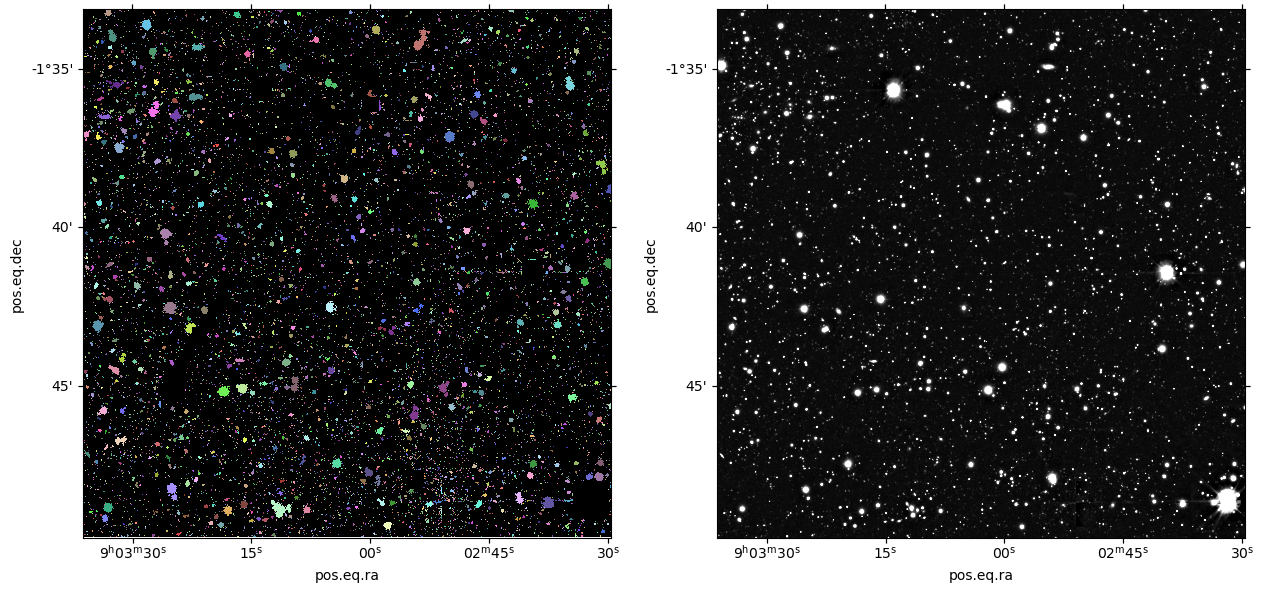

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

ax1 = plt.subplot(1, 2, 1, projection = header_Z)
ax1.imshow(segment_map, origin='lower', cmap=segment_map.cmap, interpolation='nearest')
ax2 = plt.subplot(1, 2, 2, projection = header_Z)
ax2.imshow(filt_data_HSC_Z, origin='lower', cmap = 'Greys_r', vmax=2, vmin=-.1)

Deblending multiple small sources taken as one big source by the segmentation image

In [12]:
segm_deblend = deblend_sources(convolved_data, segment_map, npixels=10, nlevels=35, contrast=0.001, progress_bar=False) # Deblending the sources

Plotting Deblended and Segmentation Image side by side

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

ax1 = plt.subplot(1, 2, 1, projection = header_Z)
ax1.title.set_text('Deblended Image')
ax1.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap, interpolation='nearest')
ax2 = plt.subplot(1, 2, 2, projection = header_Z)
ax2.title.set_text('Segmentation Image')
ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap, interpolation='nearest')
plt.savefig('Deblended vs Segmentation')

Creating a source catalog using the filtered data, the segmentation image and concolved data. Taking local background with as 5 pixels for background estimation

In [13]:
cat = SourceCatalog(filt_data_HSC_Z, segm_deblend, convolved_data=convolved_data, localbkg_width=5, wcs=header_Z, mask=mask)
Z_sources = cat.to_table() #Saving source catalog as an astropy table

Saving sources as base sources

In [14]:
Z_sourcesdf= Z_sources.to_pandas()
Z_sourcesdf.to_csv('Catalog_base_HSC_sources.csv')

## **Creating apertures for forced photometry using sources detected in Z band**

Making Elliptical Apertures with sky coordinates as we have apertures of different shapes.

In [15]:
# Converting semimajor axis and semiminor axis into arcseconds by multiplying the pixel size in degrees by 3600 as the code 
# takes a and b in arcsecond units.
a = Z_sources['semimajor_sigma'].value*.167999999999904*u.arcsec
b = Z_sources['semiminor_sigma'].value*.167999999999904*u.arcsec

apertures = []
for i in range(len(Z_sources)):
    apertures.append(SkyEllipticalAperture(Z_sources['sky_centroid'][i], a[i], b[i], Z_sources['orientation'][i]))

## **Photometry on other bands using the sources detected in Z band**

Opening HST file with filter F110

In [18]:
open_HST_F110 = fits.open(HST_F110_name)
img_HST_F110  = open_HST_F110[1]
data_HST_F110 = img_HST_F110.data.astype('float32')
header_F110 = WCS(img_HST_F110)

The HST File and HSC File span different range of coordinates. They overlap on some. To find the flux on those apertures, first perform aperture photometry on all apertures. The ones that don't overlap will have 'nan' values. Exclude them and store the rest. Now, since we don't need all the apertures anymore, make a new aperture with only the overlapping positions.

In [19]:
Flux_F110 = []
x_centroid = []
y_centroid = []
Flux_Z     = []
a = Z_sources['semimajor_sigma'].value*.167999999999904*u.arcsec
b = Z_sources['semiminor_sigma'].value*.167999999999904*u.arcsec
apertures_new = []
orientation = []
Sky_Cent = []
semimajor = []
semiminor = []

for i in range(len(Z_sources)):
    phot_F110 = aperture_photometry(data_HST_F110, apertures[i], wcs=header_F110) # aperture_photometry
    if np.isnan(phot_F110['aperture_sum']) == False:
        Flux_F110.append(phot_F110['aperture_sum'].value)
        x_centroid.append(Z_sources['xcentroid'][i])
        y_centroid.append(Z_sources['ycentroid'][i])
        Flux_Z.append(Z_sources['kron_flux'][i])
        Sky_Cent.append(Z_sources['sky_centroid'][i])
        orientation.append(Z_sources['orientation'][i])
        semimajor.append(a[i])
        semiminor.append(b[i])
        apertures_new.append(SkyEllipticalAperture(Z_sources['sky_centroid'][i], a[i], b[i], Z_sources['orientation'][i]))
        print(i)

15876
16014
16034
16078
16139
16150
16158
16310
16339
16354
16379
16388
16393
16416
16417
16430
16448
16476
16477
16494
16496
16512
16521
16522
16523
16529
16607
16630
16631
16652
16701
16709
16728
16742
16754
16756
16786
16830
16836
16840
16866
16874
16879
16885
16886
16899
16900
16907
16956
16959
16963
16976
16987
17006
17048
17075
17079
17087
17101
17111
17116
17122
17132
17167
17195
17228
17261
17262
17263
17264
17268
17294
17322
17323
17326
17329
17344
17345
17364
17380
17383
17384
17398
17413
17430
17441
17442
17443
17444
17447
17448
17464
17465
17479
17480
17484
17491
17492
17501
17504
17513
17539
17543
17550
17564
17572
17591
17592
17595
17600
17612
17613
17625
17631
17634
17635
17639
17643
17652
17661
17662
17711
17719
17723
17735
17740
17755
17767
17771
17775
17776
17789
17790
17799
17801
17841
17847
17848
17856
17872
17873
17876
17883
17905
17906
17911
17914
17926
17935
17940
17942
17957
17958
17967
17973
17979
17980
17998
17999
18019
18020
18021
18031
18032
18033
18040
1804

Store the Flux values in a list.

In [20]:
Flux_F110_HST = []
for i in range(len(Flux_F110)):
    for j in range(len(Flux_F110[i])):
        Flux_F110_HST.append(Flux_F110[i][j])

Make a dataframe and save the final x and y coordinates, the sky coordinates and flux from Z and F110 filter

In [25]:
Source_Catalog = pd.DataFrame()
Source_Catalog['x_centroid'] = x_centroid
Source_Catalog['y_centroid'] = y_centroid
skycoord = []
skycoord_ra  = []
skycoord_dec = []
for i in range(len(Source_Catalog)):
    skycoord.append(header_Z.pixel_to_world(x_centroid[i], y_centroid[i]))
    skycoord_ra.append(skycoord[0].ra.value)
    skycoord_dec.append(skycoord[0].dec.value)
Source_Catalog['RA']  = skycoord_ra
Source_Catalog['DEC'] = skycoord_dec
Source_Catalog['Flux_Z'] = Flux_Z
Source_Catalog['Flux_F110'] = Flux_F110_HST

Open HST file with Filter F160

In [28]:
open_HST_F160 = fits.open(HST_F160_name)
img_HST_F160  = open_HST_F160[1]
data_HST_F160 = img_HST_F160.data.astype('float32')
header_F160 = WCS(img_HST_F160)

Using the new apertures perform aperture photometry on HST data and save the flux

In [30]:
Flux_F160 = []

for i in range(len(apertures_new)):
    phot_F160 = aperture_photometry(data_HST_F160, apertures_new[i], wcs=header_F160) # aperture_photometry
    if np.isnan(phot_F160['aperture_sum']) == False:
        Flux_F160.append(phot_F160['aperture_sum'].value)

Store the flux values in a list.

In [31]:
Flux_F160_HST = []
for i in range(len(Flux_F160)):
    for j in range(len(Flux_F160[i])):
        Flux_F160_HST.append(Flux_F160[i][j])
Source_Catalog['Flux_F160'] = Flux_F160_HST

Repeat for HSC Filter R

In [38]:
open_HSC_R = fits.open(HSC_R_name)
img_HSC_R  = open_HSC_R[1]
data_HSC_R = img_HSC_R.data.astype('float32')
header_R   = WCS(img_HSC_R.header)

In [33]:
sigma_clip = SigmaClip(sigma=3.0)
bkg = MeanBackground(sigma_clip)
bkg_value = bkg.calc_background(data_HSC_R)
filt_data_HSC_R = data_HSC_R - bkg_value

In [40]:
Flux_R = []

for i in range(len(apertures_new)):
    phot_R = aperture_photometry(filt_data_HSC_R, apertures_new[i], wcs=header_R) # aperture_photometry
    if np.isnan(phot_R['aperture_sum']) == False:
        Flux_R.append(phot_R['aperture_sum'].value)

In [41]:
Flux_R_HSC = []
for i in range(len(Flux_R)):
    for j in range(len(Flux_R[i])):
        Flux_R_HSC.append(Flux_R[i][j])
Source_Catalog['Flux_R'] = Flux_R_HSC

Repeat for HSC Filter I

In [42]:
open_HSC_I = fits.open(HSC_I_name)
img_HSC_I  = open_HSC_I[1]
data_HSC_I = img_HSC_I.data.astype('float32')
header_I   = WCS(img_HSC_I.header)

In [43]:
sigma_clip = SigmaClip(sigma=3.0)
bkg = MeanBackground(sigma_clip)
bkg_value = bkg.calc_background(data_HSC_I)
filt_data_HSC_I = data_HSC_I - bkg_value

In [44]:
Flux_I = []

for i in range(len(apertures_new)):
    phot_I = aperture_photometry(filt_data_HSC_I, apertures_new[i], wcs=header_I) # aperture_photometry
    if np.isnan(phot_I['aperture_sum']) == False:
        Flux_I.append(phot_I['aperture_sum'].value)

In [45]:
Flux_I_HSC = []
for i in range(len(Flux_I)):
    for j in range(len(Flux_I[i])):
        Flux_I_HSC.append(Flux_I[i][j])
Source_Catalog['Flux_I'] = Flux_I_HSC

Repeat for HSC Filter G

In [46]:
open_HSC_G = fits.open(HSC_G_name)
img_HSC_G  = open_HSC_G[1]
data_HSC_G = img_HSC_G.data.astype('float32')
header_G   = WCS(img_HSC_G.header)

In [47]:
sigma_clip = SigmaClip(sigma=3.0)
bkg = MeanBackground(sigma_clip)
bkg_value = bkg.calc_background(data_HSC_G)
filt_data_HSC_G = data_HSC_G - bkg_value

In [50]:
Flux_G = []

for i in range(len(apertures_new)):
    phot_G = aperture_photometry(filt_data_HSC_G, apertures_new[i], wcs=header_G) # aperture_photometry
    if np.isnan(phot_G['aperture_sum']) == False:
        Flux_G.append(phot_G['aperture_sum'].value)

In [51]:
Flux_G_HSC = []
for i in range(len(Flux_G)):
    for j in range(len(Flux_G[i])):
        Flux_G_HSC.append(Flux_G[i][j])
Source_Catalog['Flux_G'] = Flux_G_HSC

Repeat for HSC Filter Y

In [56]:
open_HSC_Y = fits.open(HSC_Y_name)
img_HSC_Y  = open_HSC_Y[1]
data_HSC_Y = img_HSC_Y.data.astype('float32')
header_Y   = WCS(img_HSC_Y.header)

In [57]:
sigma_clip = SigmaClip(sigma=3.0)
bkg = MeanBackground(sigma_clip)
bkg_value = bkg.calc_background(data_HSC_Y)
filt_data_HSC_Y = data_HSC_Y - bkg_value

In [58]:
Flux_Y = []

for i in range(len(apertures_new)):
    phot_Y = aperture_photometry(filt_data_HSC_Y, apertures_new[i], wcs=header_Y) # aperture_photometry
    if np.isnan(phot_Y['aperture_sum']) == False:
        Flux_Y.append(phot_Y['aperture_sum'].value)

In [59]:
Flux_Y_HSC = []
for i in range(len(Flux_Y)):
    for j in range(len(Flux_Y[i])):
        Flux_Y_HSC.append(Flux_Y[i][j])
Source_Catalog['Flux_Y'] = Flux_Y_HSC

In [61]:
Source_Catalog.to_csv('Source_Catalog_HSC_HST.csv')